# Project : Classifying Genetic Mutations based on clinical evidence 

# Kaggle Problem

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Memorial Sloan Kettering Cancer Center (MSKCC) launched this competition, accepted by the NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.


In this competition we will develop algorithms to classify genetic mutations based on clinical evidence (text).

There are nine different classes a genetic mutation can be classified on (1 to 9).

More details about the competetion on :
**https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview**

## Loading the packages and training data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [2]:
#reading the file named variants

data_variants = pd.read_csv('training_variants')

In [3]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
#reading the file named training_text

data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
#checking the shape
data_variants.shape

(3321, 4)

In [7]:
#checking the columns
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [8]:
data_text.shape

(3321, 2)

In [9]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [10]:
#checking the number of classes
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [11]:
#downloading stop words from nltk
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [12]:
#stop words
stop_words = set(stopwords.words('english'))

In [13]:
#text preprocessing fucntion. We have huge amount of text we need to pre-process it. 
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [14]:
#apply the function to data_text.
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [15]:
#merge the data sets based on ID
result = pd.merge(data_variants, data_text, on= 'ID', how= 'left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [16]:
#checking for nulls
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [17]:
#checking for nulls
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [18]:
#imputing the missing values
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [19]:
#checking for nulls
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


## Creating Train, Test and Validation Data

In [20]:
#replacing the spaces with _

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('/s+','_')
result.Variation = result.Variation.str.replace('/s+','_')

In [21]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [22]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [23]:
#checking for the distribution of class columns
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

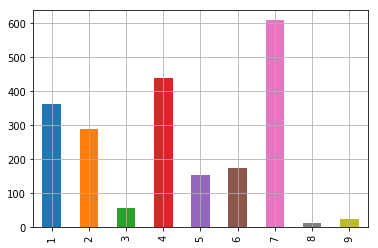

In [24]:
#plot the distribution
train_class_distribution.plot(kind = 'bar')
plt.grid()

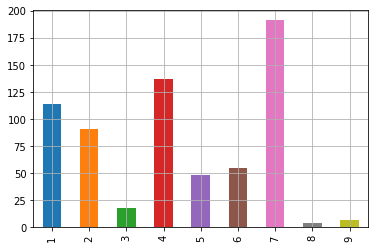

In [25]:
test_class_distribution.plot(kind= 'bar')
plt.grid()

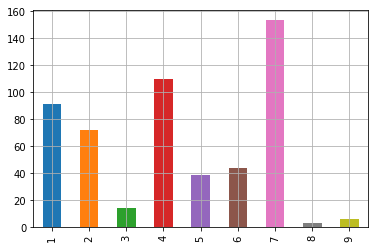

In [26]:
cv_class_distribution.plot(kind = 'bar')
plt.grid()

## Building the Random model

In [27]:
#length of test and validation dat
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [28]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.4405544427793786


In [29]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on Test Data using Random Model 2.5407198886541766


In [30]:
#lets get the predicted ys
predicted_y = np.argmax(test_predicted_y, axis = 1)
predicted_y = predicted_y + 1
predicted_y

array([2, 8, 3, 7, 2, 1, 1, 9, 1, 8, 4, 9, 1, 3, 4, 7, 8, 6, 1, 8, 8, 2,
       7, 8, 6, 1, 5, 5, 7, 1, 6, 2, 2, 8, 3, 8, 6, 9, 4, 1, 1, 9, 5, 2,
       7, 9, 2, 7, 2, 3, 3, 8, 5, 3, 5, 6, 3, 5, 7, 8, 7, 9, 2, 9, 5, 9,
       2, 2, 8, 7, 7, 2, 1, 9, 8, 7, 4, 7, 9, 4, 2, 3, 3, 7, 5, 7, 4, 3,
       6, 6, 3, 5, 7, 5, 5, 9, 5, 3, 6, 3, 5, 1, 7, 2, 5, 9, 8, 2, 1, 8,
       5, 9, 9, 2, 5, 5, 3, 8, 6, 6, 2, 5, 3, 3, 6, 7, 7, 8, 1, 1, 7, 9,
       9, 1, 9, 2, 4, 6, 9, 4, 9, 7, 2, 8, 5, 9, 6, 8, 8, 5, 3, 1, 2, 1,
       7, 4, 7, 4, 1, 8, 5, 9, 2, 6, 4, 4, 6, 6, 1, 4, 2, 6, 8, 7, 9, 3,
       1, 3, 8, 8, 6, 2, 8, 9, 3, 4, 5, 7, 7, 3, 8, 3, 2, 1, 5, 3, 8, 2,
       5, 8, 5, 5, 7, 3, 1, 5, 6, 3, 7, 4, 8, 8, 2, 9, 9, 7, 8, 4, 1, 5,
       8, 8, 9, 9, 4, 3, 6, 7, 9, 2, 5, 4, 8, 6, 3, 7, 6, 3, 2, 8, 3, 8,
       7, 4, 7, 3, 1, 4, 9, 6, 9, 5, 5, 4, 8, 4, 4, 3, 2, 9, 3, 9, 9, 5,
       1, 2, 2, 4, 9, 4, 4, 1, 9, 4, 9, 9, 7, 5, 5, 7, 9, 4, 7, 3, 5, 6,
       7, 2, 7, 6, 5, 7, 8, 1, 7, 5, 2, 3, 9, 3, 9,

In [31]:
#confusion matrix

C = confusion_matrix(y_test, predicted_y)

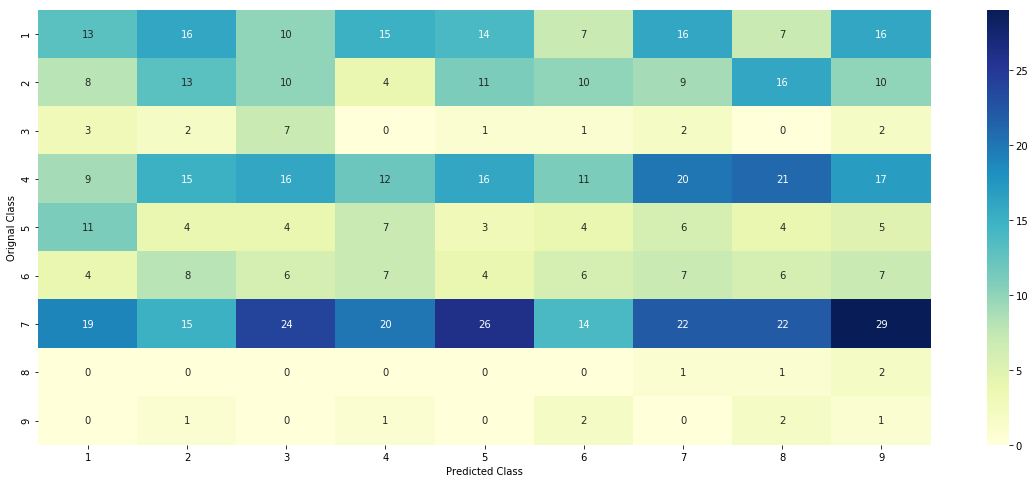

In [32]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize = (20,8))
sns.heatmap(C, cmap= 'YlGnBu', xticklabels= labels, yticklabels= labels, annot= True)
plt.xlabel('Predicted Class')
plt.ylabel('Orignal Class')
plt.show()

## Precision Matrix

In [33]:
B =(C/C.sum(axis=0))

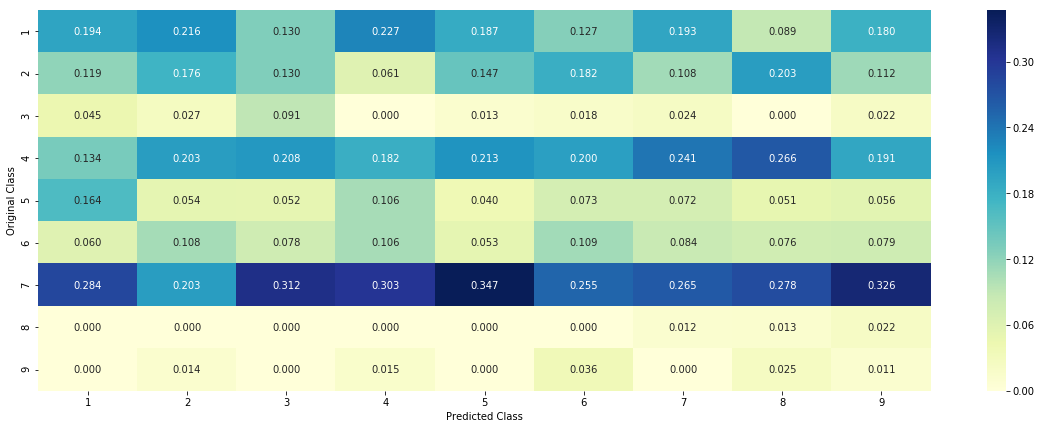

In [34]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Recall Matrix

In [35]:
A =(((C.T)/(C.sum(axis=1))).T)

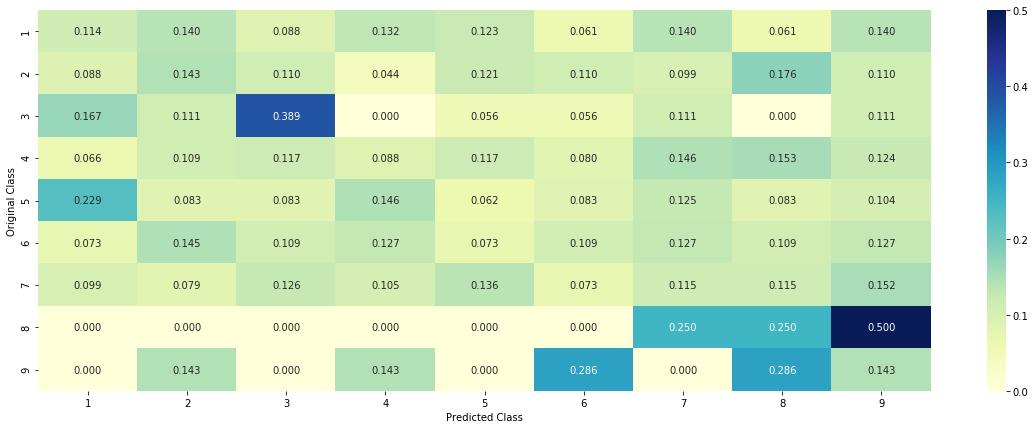

In [36]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## Exploring the gene column

In [37]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
BRCA1     176
TP53      106
EGFR       87
BRCA2      81
PTEN       78
BRAF       64
KIT        61
ALK        54
ERBB2      47
PDGFRA     40
Name: Gene, dtype: int64


In [38]:
unique_genes.shape

(236,)

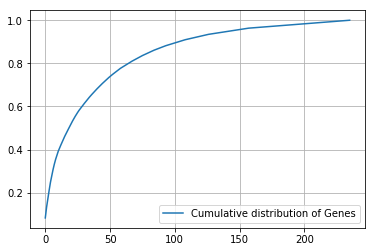

In [39]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it.

***One-hot encoding***

***Response Encoding*** (Mean imputation)


Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [40]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [41]:
#checking the shape
train_gene_feature_onehotCoding.shape

(2124, 235)

In [42]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [43]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [44]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [45]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-10, 2)]

In [46]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-10 The log loss is: 1.5202417968047568
For values of alpha =  1e-09 The log loss is: 1.5190088554996142
For values of alpha =  1e-08 The log loss is: 1.5102582422885629
For values of alpha =  1e-07 The log loss is: 1.5036427561788888
For values of alpha =  1e-06 The log loss is: 1.4952352123294455
For values of alpha =  1e-05 The log loss is: 1.394942762764123
For values of alpha =  0.0001 The log loss is: 1.253180508304022
For values of alpha =  0.001 The log loss is: 1.2627746703698774
For values of alpha =  0.01 The log loss is: 1.3640204492938388
For values of alpha =  0.1 The log loss is: 1.4593093481929271
For values of alpha =  1 The log loss is: 1.4927536124471836
For values of alpha =  10 The log loss is: 1.4973740241376956


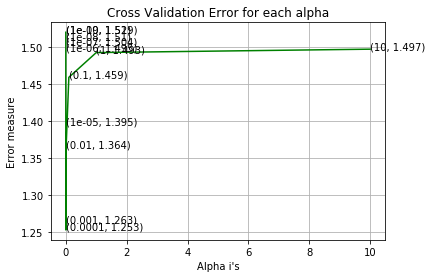

In [47]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [48]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 1.0144695710429752
For values of best alpha =  0.0001 The cross validation log loss is: 1.253180508304022
For values of best alpha =  0.0001 The test log loss is: 1.2421049851257906


In [49]:
#Now lets check how many values are overlapping between train, test or between CV and train
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 515 out of  532 : 96.80451127819549


## Evaluating Variation column

In [50]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1929
Truncating Mutations    65
Amplification           46
Deletion                42
Fusions                 18
G12V                     3
Y64A                     2
Y42C                     2
F28L                     2
Q61H                     2
Q22K                     2
Name: Variation, dtype: int64


[0.03060264 0.05225989 0.0720339  ... 0.99905838 0.99952919 1.        ]


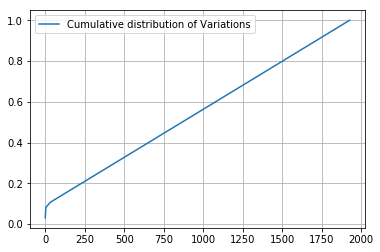

In [51]:
#Lets look at the comulative distribution of unique variation values
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [52]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [53]:
train_variation_feature_onehotCoding.shape

(2124, 1953)

In [54]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [55]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [56]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7323040580676852
For values of alpha =  0.0001 The log loss is: 1.6870947764262574
For values of alpha =  0.001 The log loss is: 1.6764337112223875
For values of alpha =  0.01 The log loss is: 1.6872259579485802
For values of alpha =  0.1 The log loss is: 1.707676384891236
For values of alpha =  1 The log loss is: 1.7118739063153563


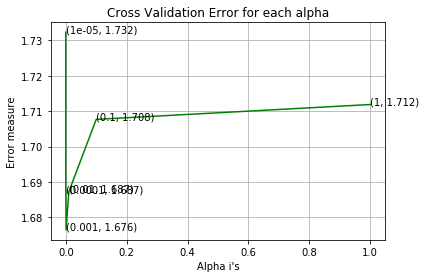

In [57]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [58]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.2055786941780144
For values of best alpha =  0.001 The cross validation log loss is: 1.6764337112223875
For values of best alpha =  0.001 The test log loss is: 1.7211396105467156


In [59]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 69 out of 665 : 10.37593984962406
2. In cross validation data 57 out of  532 : 10.714285714285714


## Evaluating Text Column

In [60]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [61]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [62]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53587


In [63]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [64]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [65]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [66]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [67]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [68]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5209, 4: 3573, 5: 2995, 6: 2948, 8: 2247, 7: 1910, 12: 1767, 10: 1602, 9: 1530, 11: 1051, 15: 989, 14: 970, 13: 861, 16: 765, 20: 658, 18: 655, 24: 603, 17: 568, 19: 472, 22: 462, 21: 458, 25: 435, 23: 380, 28: 377, 30: 351, 27: 333, 41: 327, 26: 327, 35: 312, 36: 295, 52: 278, 40: 275, 33: 263, 32: 262, 29: 251, 31: 246, 37: 233, 34: 228, 42: 218, 48: 200, 39: 193, 44: 189, 46: 188, 45: 180, 38: 180, 43: 164, 50: 161, 60: 158, 53: 153, 47: 152, 56: 147, 51: 140, 49: 134, 54: 133, 58: 130, 55: 129, 57: 118, 80: 117, 65: 115, 64: 114, 62: 109, 69: 108, 63: 107, 66: 104, 70: 103, 72: 102, 75: 100, 61: 99, 67: 98, 78: 94, 71: 94, 76: 91, 59: 90, 84: 87, 68: 85, 83: 84, 77: 84, 81: 76, 74: 74, 93: 73, 102: 72, 85: 72, 79: 70, 73: 70, 90: 69, 82: 68, 105: 66, 97: 66, 92: 66, 86: 64, 89: 62, 88: 62, 120: 61, 99: 60, 96: 58, 87: 57, 104: 56, 107: 55, 91: 55, 95: 54, 94: 53, 125: 52, 100: 52, 98: 52, 119: 50, 113: 47, 106: 47, 128: 46, 115: 46, 109: 46, 108: 46, 140: 44, 114: 44, 1

In [69]:
#building model with only text column
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.390619621458123
For values of alpha =  0.0001 The log loss is: 1.344528392461115
For values of alpha =  0.001 The log loss is: 1.1995713073277179
For values of alpha =  0.01 The log loss is: 1.2453113843660308
For values of alpha =  0.1 The log loss is: 1.5155265416839179
For values of alpha =  1 The log loss is: 1.703616352534625


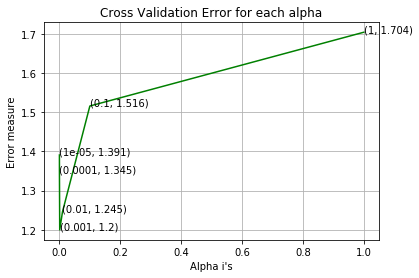

In [70]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [71]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  0.001 The train log loss is: 0.7652632227443311
For values of best alpha =  0.001 The cross validation log loss is: 1.1995713073277179
For values of best alpha =  0.001 The test log loss is: 1.2439845288195914


In [72]:
#checking the overlap of data
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [73]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.229 % of word of test data appeared in train data
98.24 % of word of Cross Validation appeared in train data


## Data Prep for ML Models

In [74]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [75]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [76]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [77]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [78]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55775)
(number of data points * number of features) in test data =  (665, 55775)
(number of data points * number of features) in cross validation data = (532, 55775)


In [79]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building the ML Models

## Naive Bayes

In [80]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2638923857957207
for alpha = 0.0001
Log Loss : 1.2646650559380503
for alpha = 0.001
Log Loss : 1.2715654340493605
for alpha = 0.1
Log Loss : 1.2801317412142672
for alpha = 1
Log Loss : 1.2662083189616038
for alpha = 10
Log Loss : 1.3116928112063049
for alpha = 100
Log Loss : 1.325983866528834
for alpha = 1000
Log Loss : 1.2588168985748895


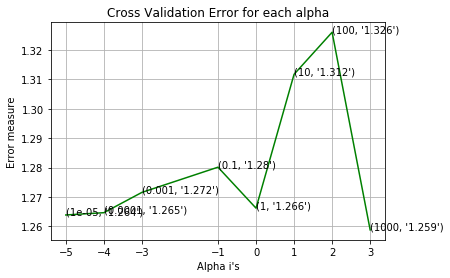

In [81]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [82]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of best alpha =  1000 The train log loss is: 1.036174484703867
For values of best alpha =  1000 The cross validation log loss is: 1.2588168985748895
For values of best alpha =  1000 The test log loss is: 1.2859298244000825


Log Loss : 1.2588168985748895
Number of missclassified point : 0.4041353383458647
-------------------- Confusion matrix --------------------


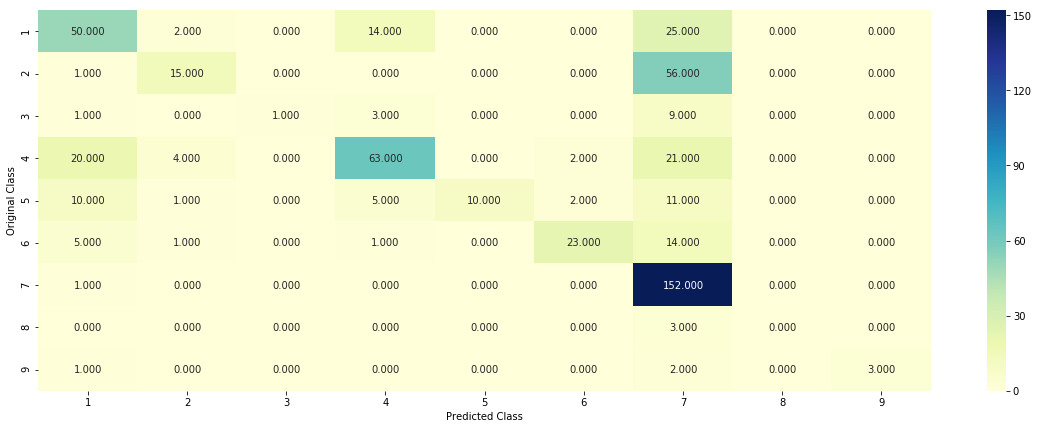

-------------------- Precision matrix (Columm Sum=1) --------------------


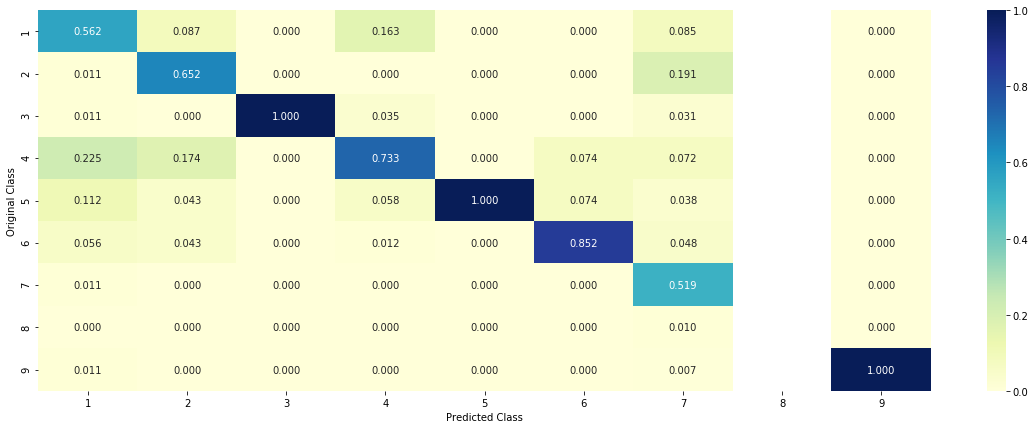

-------------------- Recall matrix (Row sum=1) --------------------


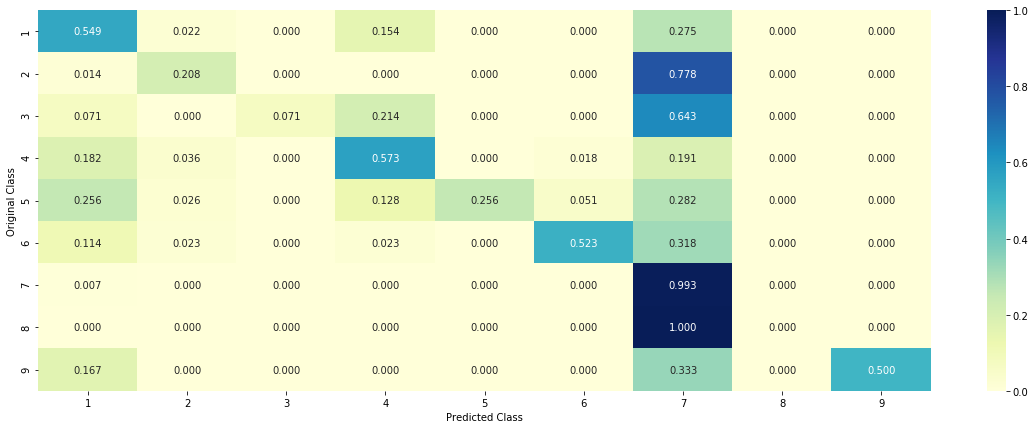

In [83]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

# Inter operability of model

In [84]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[8.500e-03 1.517e-01 5.000e-04 1.030e-02 4.800e-03 4.000e-03 8.187e-01
  1.500e-03 0.000e+00]]
Actual Class : 2
--------------------------------------------------
19 Text feature [kinase] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [presence] present in test data point [True]
23 Text feature [downstream] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
26 Text feature [contrast] present in test data point [True]
27 Text feature [well] present in test data point [True]
28 Text feature [however] present in test data point [True]
29 Text feature [potential] present in test data point [True]
30 Text feature [recently] present in test data point [True]
31 Text feature [suggest] present in test data point [True]
32 Text feature [shown] present in test data point [True]
33 Text feature [previously] present in test data point [T

In [85]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.620e-02 3.000e-02 7.700e-03 8.201e-01 2.270e-02 1.900e-02 7.120e-02
  2.400e-03 8.000e-04]]
Actual Class : 4
--------------------------------------------------
12 Text feature [function] present in test data point [True]
13 Text feature [protein] present in test data point [True]
16 Text feature [proteins] present in test data point [True]
17 Text feature [missense] present in test data point [True]
18 Text feature [mammalian] present in test data point [True]
19 Text feature [experiments] present in test data point [True]
20 Text feature [acid] present in test data point [True]
21 Text feature [functional] present in test data point [True]
22 Text feature [amino] present in test data point [True]
24 Text feature [activity] present in test data point [True]
25 Text feature [results] present in test data point [True]
26 Text feature [retained] present in test data point [True]
28 Text feature [ability] present in test data point [Tr

# Logistic Regression

In [86]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.3937458389460737
for alpha = 1e-05
Log Loss : 1.3889690684186724
for alpha = 0.0001
Log Loss : 1.287839520923412
for alpha = 0.001
Log Loss : 1.101043938027437
for alpha = 0.01
Log Loss : 1.125771253606319
for alpha = 0.1
Log Loss : 1.4402997979320877
for alpha = 1
Log Loss : 1.6812226351238997
for alpha = 10
Log Loss : 1.7081485271538226
for alpha = 100
Log Loss : 1.7108726915897017


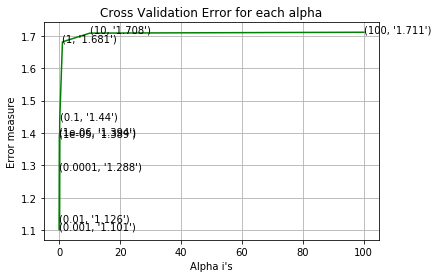

In [87]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [88]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6202828017949225
For values of best alpha =  0.001 The cross validation log loss is: 1.101043938027437
For values of best alpha =  0.001 The test log loss is: 1.159058069021908


Log loss : 1.101043938027437
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


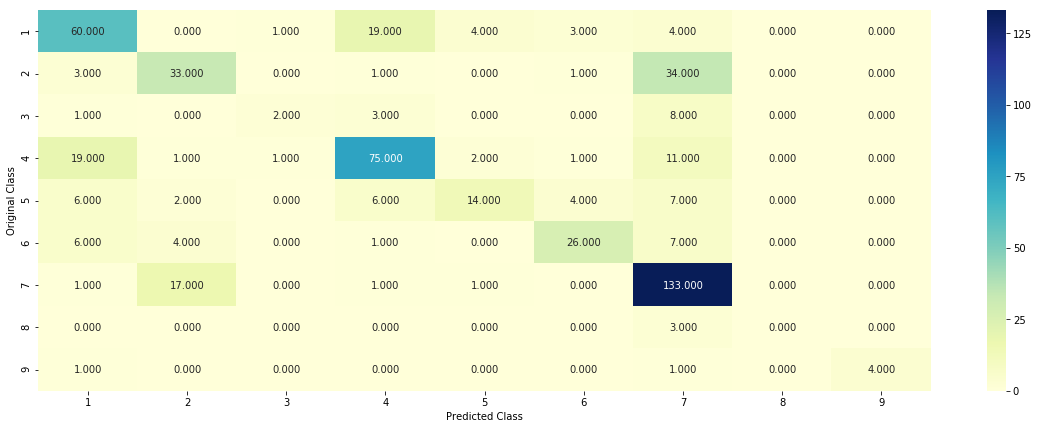

-------------------- Precision matrix (Columm Sum=1) --------------------


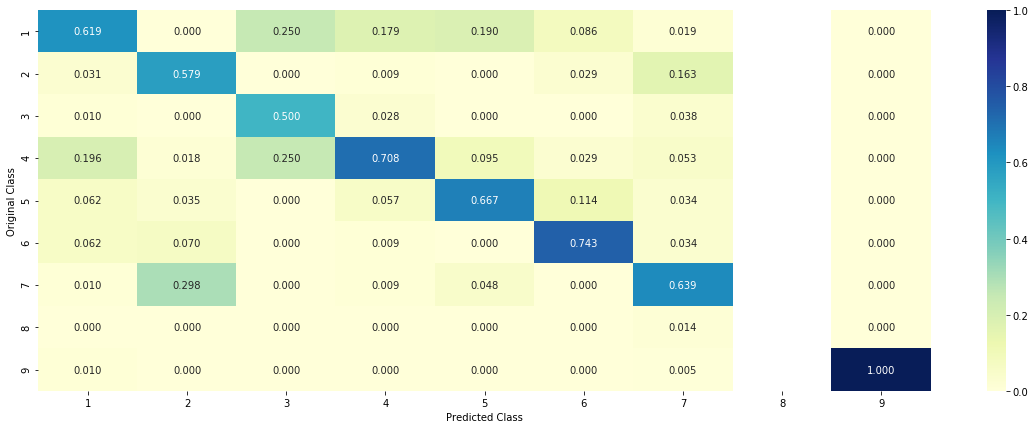

-------------------- Recall matrix (Row sum=1) --------------------


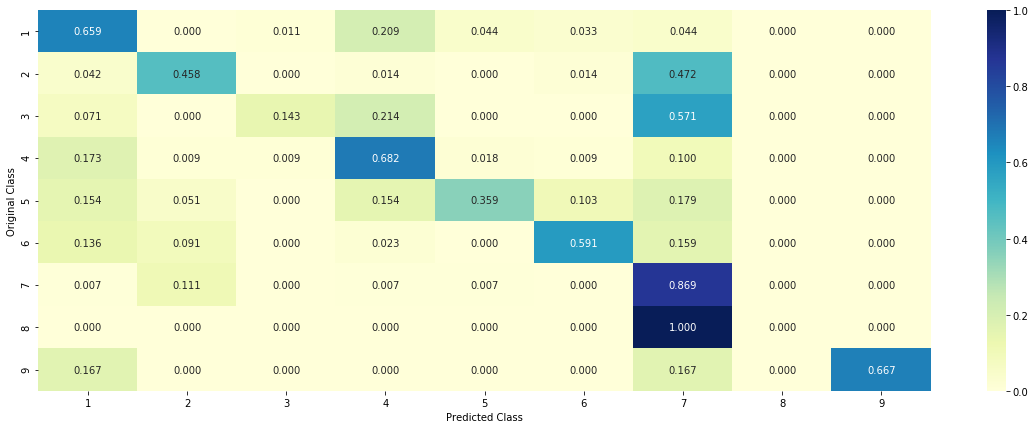

In [89]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [90]:
#getting the predictions on test
predict_y = sig_clf.predict_proba(test_x_onehotCoding)

In [91]:
predict_y

array([[6.75734955e-02, 3.56663312e-01, 1.38538950e-02, ...,
        3.96422826e-01, 5.10337632e-03, 6.34942235e-03],
       [6.66968093e-03, 4.43751532e-01, 4.05105521e-04, ...,
        5.34014834e-01, 5.20459997e-03, 2.36579857e-03],
       [1.77781586e-02, 4.22017649e-01, 2.17330382e-03, ...,
        5.30201578e-01, 3.92929241e-03, 2.29799811e-03],
       ...,
       [1.85015510e-02, 2.26431366e-02, 1.41451971e-01, ...,
        8.87519440e-03, 4.42888456e-03, 3.27035946e-03],
       [5.38939304e-01, 4.53689803e-02, 6.55088580e-03, ...,
        3.61881167e-02, 4.66959798e-03, 4.42881621e-03],
       [8.63981560e-02, 9.43121819e-02, 1.56647054e-02, ...,
        1.26206397e-01, 4.91886058e-03, 2.18382016e-02]])

In [92]:
#getting into array form
predicted_y = np.argmax(predict_y, axis = 1)

In [93]:
#add one to get the real class
predicted_y = predicted_y + 1

In [94]:
predicted_y

array([7, 7, 7, 7, 1, 7, 6, 1, 4, 4, 6, 7, 7, 7, 6, 1, 7, 5, 1, 4, 9, 7,
       2, 4, 4, 1, 6, 1, 1, 1, 5, 1, 3, 1, 3, 1, 4, 7, 6, 7, 7, 1, 1, 7,
       1, 1, 7, 4, 7, 7, 7, 7, 7, 7, 2, 1, 7, 6, 4, 4, 4, 7, 4, 1, 7, 7,
       7, 2, 7, 5, 7, 3, 4, 2, 7, 7, 1, 7, 7, 1, 4, 7, 6, 1, 7, 4, 1, 6,
       7, 4, 7, 1, 5, 4, 4, 6, 7, 5, 2, 5, 4, 1, 7, 2, 7, 1, 7, 1, 7, 2,
       7, 4, 7, 4, 5, 1, 7, 7, 6, 4, 7, 4, 7, 4, 3, 7, 4, 1, 7, 6, 7, 4,
       7, 1, 4, 3, 4, 2, 7, 2, 2, 7, 4, 7, 4, 1, 7, 4, 2, 7, 2, 7, 1, 1,
       4, 4, 1, 7, 3, 1, 1, 2, 4, 1, 4, 1, 7, 4, 4, 4, 7, 7, 7, 6, 7, 6,
       4, 7, 5, 7, 7, 6, 7, 6, 7, 4, 4, 4, 7, 4, 6, 2, 1, 1, 7, 1, 5, 1,
       7, 4, 1, 7, 7, 7, 1, 2, 7, 1, 4, 1, 4, 4, 2, 7, 7, 4, 7, 7, 6, 7,
       4, 2, 4, 4, 7, 4, 7, 9, 7, 2, 7, 4, 2, 7, 1, 7, 2, 4, 3, 3, 1, 2,
       4, 4, 2, 7, 7, 7, 7, 6, 7, 7, 4, 7, 1, 5, 4, 7, 7, 7, 1, 9, 7, 5,
       2, 1, 7, 7, 7, 1, 9, 1, 1, 7, 7, 4, 2, 7, 4, 1, 4, 2, 1, 4, 4, 7,
       5, 4, 1, 7, 4, 1, 7, 5, 3, 7, 7, 4, 7, 6, 4,

## Working on Test Data from Kaggle

In [95]:
#reading the test variants
my_test_variants = pd.read_csv('test_variants')

In [96]:
#reading the text data
my_test_text = pd.read_csv("test_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [97]:
my_test_variants.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [98]:
my_test_text.head()

,ID,TEXT
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [99]:
#stop words
stop_words = set(stopwords.words('english'))

In [100]:
#apply the text pre-processing function to data_text.
for index, row in my_test_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

In [101]:
#merge the data
combined_data = pd.merge(my_test_variants, my_test_text, on= 'ID', how= 'left')
combined_data.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [102]:
#length of the combined data. As mentioned in kaggle some samples are machine generated. 
len(combined_data.Gene)

5668

In [103]:
#checking for nulls
combined_data[combined_data.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT
1623,1623,AURKB,Amplification,NaN


In [104]:
#imputing the missing values
combined_data.loc[combined_data['TEXT'].isnull(),'TEXT'] = combined_data['Gene'] +' '+combined_data['Variation']

In [105]:
#checking for nulls
combined_data[combined_data.isnull().any(axis=1)]

,ID,Gene,Variation,TEXT


In [107]:
#length of data
len(combined_data)

5668

In [108]:
import gc

In [109]:
#garbage collection to save memory
gc.collect()

990

In [111]:
combined_data.head()

,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [112]:
#one hot encoding using gene_vectorizer
cdata_feature_onehotCoding = gene_vectorizer.transform(combined_data['Gene'])

In [114]:
#checking the shape after gene vectorization
cdata_feature_onehotCoding.shape

(5668, 235)

In [119]:
#doing the one hot encoding for variation column
cdata_variation_onehotcoding = variation_vectorizer.transform(combined_data['Variation'])

In [120]:
#shape after variation hot encoding
cdata_variation_onehotcoding.shape

(5668, 1953)

In [121]:
#doing the same for text column
cdata_text_feature_onehotCoding = text_vectorizer.transform(combined_data['TEXT'])

In [122]:
#normalize
cdata_text_feature_onehotCoding = normalize(cdata_text_feature_onehotCoding, axis=0)

In [123]:
#one hot encoding merging
cdata_gene_var_onehotcoding = hstack((cdata_feature_onehotCoding,cdata_variation_onehotcoding))
cdata_onehotcoding = hstack((cdata_gene_var_onehotcoding, cdata_text_feature_onehotCoding)).tocsr()

In [124]:
#now we have 55775 columns , same as we trained our model on. 
cdata_onehotcoding.shape

(5668, 55775)

In [125]:
test_x_onehotCoding.shape

(665, 55775)

In [126]:
#get the predictions for kaggle submission
predict_y_fin = sig_clf.predict_proba(cdata_onehotcoding)

In [128]:
# we should have 9 columns for classes. 
predict_y_fin.shape

(5668, 9)

In [129]:
len(combined_data)

5668

In [130]:
#predictions. 
predict_y_fin

array([[0.08200016, 0.11439176, 0.01594196, ..., 0.59687423, 0.00449015,
        0.00616658],
       [0.16538004, 0.14198283, 0.02994814, ..., 0.22769745, 0.00402245,
        0.00722508],
       [0.1444598 , 0.14951696, 0.0154132 , ..., 0.41323589, 0.0059059 ,
        0.00724649],
       ...,
       [0.14967917, 0.09065194, 0.02911348, ..., 0.36899337, 0.00356846,
        0.00646201],
       [0.19049467, 0.14547794, 0.01685726, ..., 0.31532603, 0.00552782,
        0.00704767],
       [0.16072138, 0.14570826, 0.03342775, ..., 0.20472206, 0.00436968,
        0.00763888]])

In [142]:
#convert to a data frame. 
fin1 = pd.DataFrame(predict_y_fin, columns= ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 
                                            'Class 7', 'Class 8', 'Class 9'])

In [143]:
fin1.head()

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
0,0.082000,0.114392,0.015942,0.091247,0.052733,0.036155,0.596874,0.004490,0.006167
1,0.165380,0.141983,0.029948,0.264353,0.075319,0.084072,0.227697,0.004022,0.007225
2,0.144460,0.149517,0.015413,0.123552,0.077375,0.063295,0.413236,0.005906,0.007246
3,0.137939,0.188615,0.022212,0.209047,0.072061,0.060875,0.296813,0.005004,0.007434
4,0.096357,0.082397,0.006639,0.588271,0.032108,0.028591,0.155623,0.004400,0.005614


In [144]:
#export the data for submission. 
fin1.to_csv('predicted_classes.csv')

## After submitting to kaggle. 

In [161]:
#read the image file
imm = plt.imread('kaggle_submit.jpg')

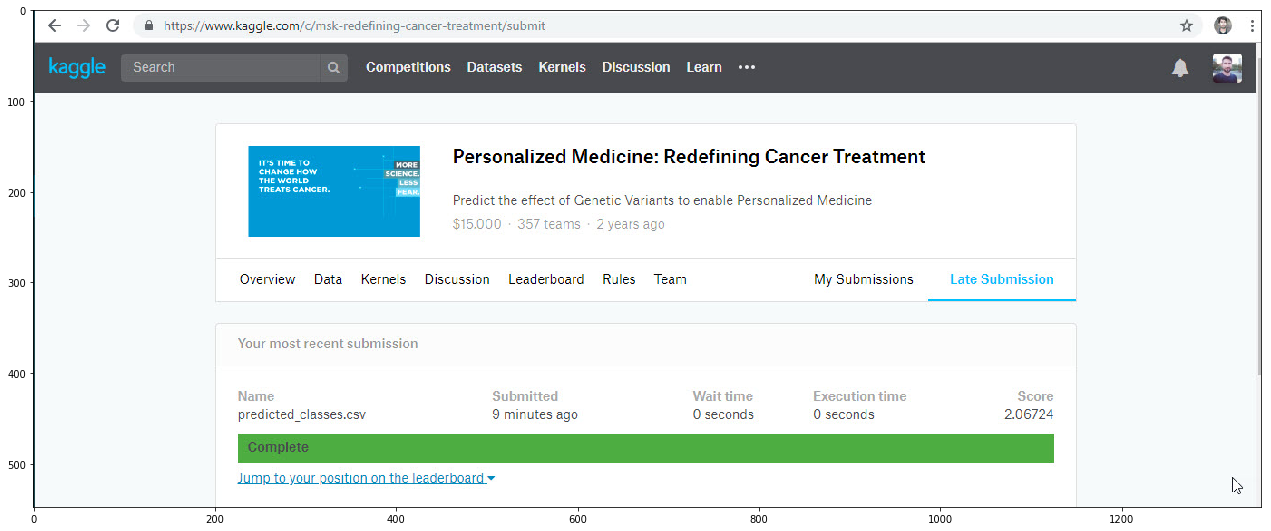

In [164]:
#display the image file from kaggle. 
plt.figure(figsize = (22,10))
plt.imshow(imm)
plt.show()